<a href="https://colab.research.google.com/github/Brun0oO/Colab/blob/main/Prompt_based_Image_In_Painting_powered_by_ClipSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on the following notebook: https://github.com/amrrs/stable-diffusion-prompt-inpainting

In [4]:
! git clone https://github.com/timojl/clipseg 

Cloning into 'clipseg'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 200 (delta 47), reused 43 (delta 42), pack-reused 145
Receiving objects: 100% (200/200), 1.39 MiB | 1.97 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [5]:
! pip install diffusers -q

     |████████████████████████████████| 255 kB 30.3 MB/s 
     |████████████████████████████████| 163 kB 71.0 MB/s 


In [6]:
! pip install transformers -q -UU ftfy gradio  

     |████████████████████████████████| 5.3 MB 18.7 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 11.6 MB 52.7 MB/s 
     |████████████████████████████████| 7.6 MB 68.7 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 106 kB 27.7 MB/s 
     |████████████████████████████████| 2.3 MB 42.0 MB/s 
     |████████████████████████████████| 272 kB 58.6 MB/s 
     |████████████████████████████████| 84 kB 2.4 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 84 kB 2.0 MB/s 
     |████████████████████████████████| 212 kB 54.3 MB/s 
     |████████████████████████████████| 63 kB 1.0 MB/s 
     |████████████████████████████████| 80 kB 8.7 MB/s 
     |████████████████████████████████| 68 kB 6.7 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |███████████████████████████

In [7]:
! pip install git+https://github.com/openai/CLIP.git -q

In [19]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [176]:
! cd /content/clipseg
! wget -nc https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
! unzip -o -q -d weights -j weights.zip

File ‘weights.zip’ already there; not retrieving.


# Interactive inputs

Saving IMG_1390.jpg to IMG_1390 (2).jpg


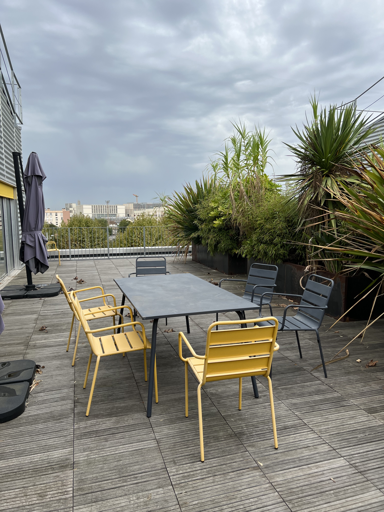

In [69]:
from inspect import EndOfBlock
import os
from PIL import Image 

def upload_files(path_dest):
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(os.path.join(path_dest,k), 'wb').write(v)
  return list(uploaded.keys())


MAX_SIZE = (512, 512)
dest = "/content"
files = upload_files(dest)
input_image = Image.open(os.path.join(dest,files[0])) 
input_image.thumbnail(MAX_SIZE)
  

display(input_image)


In [147]:

object_prompt = input("Object to replace: ")
replace_by_prompt = input("Replace this object by: ")


Object to replace: yellow chairs
Replace this object by: old armchair


In [148]:
import torch
import requests
import cv2 
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

In [149]:
from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

In [150]:
#! git lfs install

Updated git hooks.
Git LFS initialized.


In [151]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();


In [152]:
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);


In [153]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [154]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

In [155]:
!%cd /content/

In [156]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

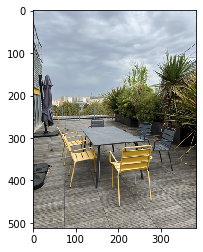

In [157]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [159]:
prompts = [object_prompt]
# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


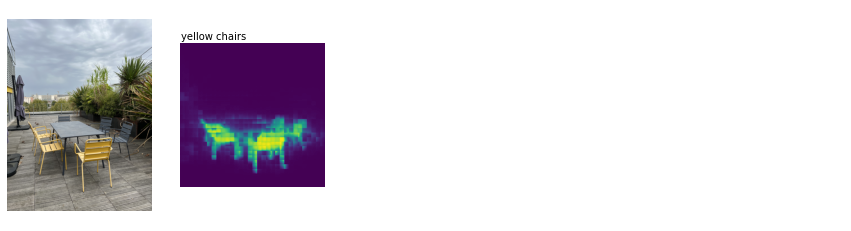

In [160]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [161]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [162]:
img2 = cv2.imread(filename)

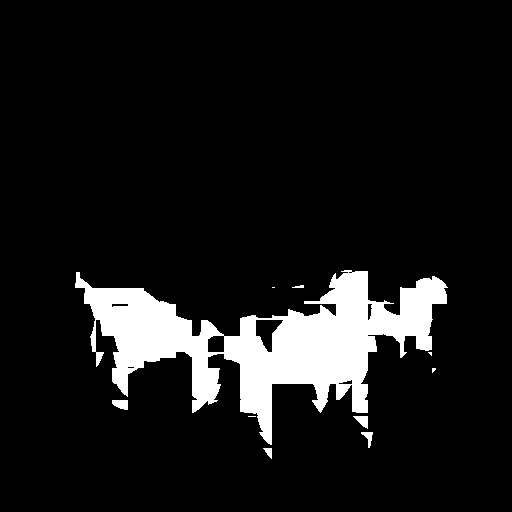

In [163]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

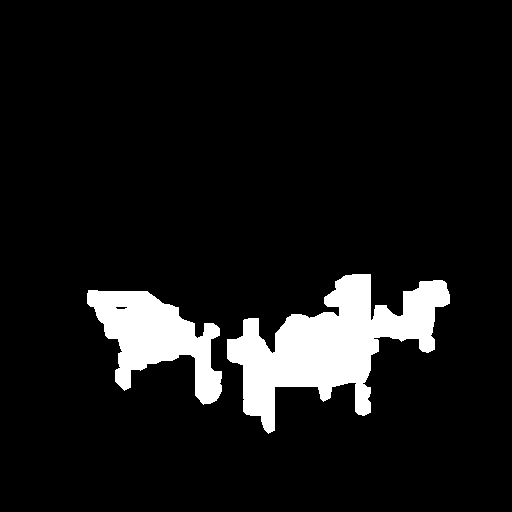

In [169]:
# attempt to enhance the mask
from PIL import Image
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
(thresh, binRed) = cv2.threshold(bw_image, 128, 255, cv2.THRESH_BINARY)
smoothed = cv2.morphologyEx(bw_image, cv2.MORPH_OPEN, kernel, iterations=3)
cv2.imwrite(filename,smoothed)
Image.fromarray(smoothed)

In [165]:
init_image = Image.open('init_image.png')
mask = Image.open('mask.png')

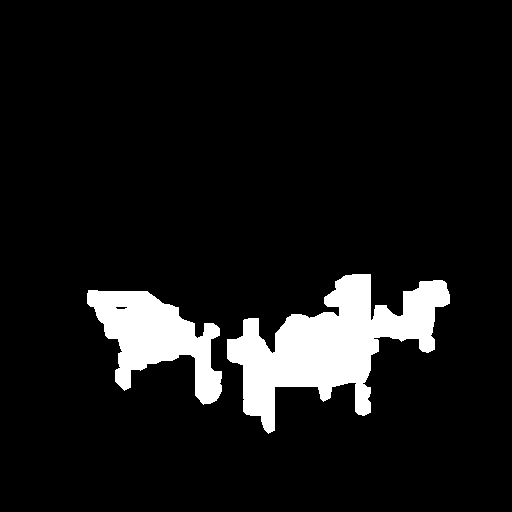

In [166]:
mask

In [167]:
with autocast("cuda"):
    images = pipe(prompt=replace_by_prompt, init_image=init_image, mask_image=mask, strength=0.9)
  

0it [00:00, ?it/s]

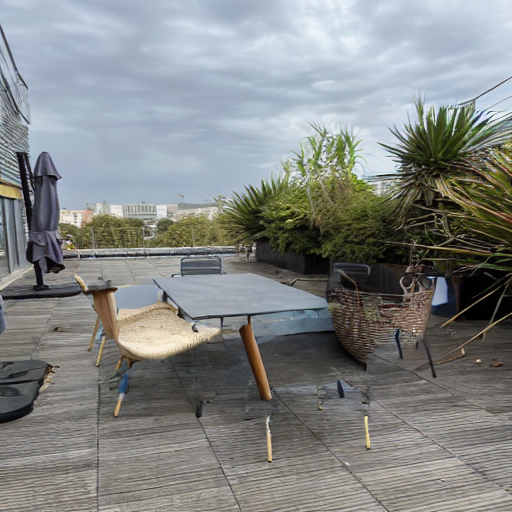

In [168]:
result=images['images'][0]
display(result)